# 论文16：用于关系推理的简单神经网络模块
## Adam Santoro, David Raposo, David G.T. Barrett, et al., DeepMind (2017)

### 关系网络 (RN)

即插即用的关系推理模块。关键洞察：显式计算成对关系！

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 关系网络架构

核心思想：
```
RN(O) = f_φ( Σ_{i,j} g_θ(o_i, o_j, q) )
```

- **g_θ**：关系函数（处理成对）
- **f_φ**：聚合函数（处理关系）
- **O**：对象集合
- **q**：查询/上下文

In [2]:
def relu(x):
    return np.maximum(0, x)

class MLP:
    """Simple multi-layer perceptron"""
    def __init__(self, input_dim, hidden_dims, output_dim):
        self.layers = []
        
        # Create layers
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            W = np.random.randn(dims[i+1], dims[i]) * 0.01
            b = np.zeros((dims[i+1], 1))
            self.layers.append((W, b))
    
    def forward(self, x):
        """Forward pass through MLP"""
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        
        for i, (W, b) in enumerate(self.layers):
            x = np.dot(W, x) + b
            # ReLU for all but last layer
            if i < len(self.layers) - 1:
                x = relu(x)
        
        return x.flatten()

# Test MLP
mlp = MLP(input_dim=10, hidden_dims=[20, 20], output_dim=5)
test_input = np.random.randn(10)
output = mlp.forward(test_input)
print(f"MLP output shape: {output.shape}")

MLP output shape: (5,)


## 关系网络模块

In [3]:
class RelationNetwork:
    """
    Relation Network for reasoning about object relationships
    
    RN(O) = f_φ( Σ_{i,j} g_θ(o_i, o_j, q) )
    """
    def __init__(self, object_dim, query_dim, g_hidden_dims, f_hidden_dims, output_dim):
        """
        object_dim: dimension of each object representation
        query_dim: dimension of query/question
        g_hidden_dims: hidden dimensions for g_θ (relation function)
        f_hidden_dims: hidden dimensions for f_φ (aggregation function)
        output_dim: final output dimension
        """
        # g_θ: processes pairs of objects + query
        g_input_dim = object_dim * 2 + query_dim
        g_output_dim = g_hidden_dims[-1] if g_hidden_dims else 256
        self.g_theta = MLP(g_input_dim, g_hidden_dims[:-1], g_output_dim)
        
        # f_φ: processes aggregated relations
        f_input_dim = g_output_dim
        self.f_phi = MLP(f_input_dim, f_hidden_dims, output_dim)
    
    def forward(self, objects, query):
        """
        objects: list of object representations (each is a vector)
        query: query/context vector
        
        Returns: output vector
        """
        n_objects = len(objects)
        
        # Compute relations for all pairs
        relations = []
        
        for i in range(n_objects):
            for j in range(n_objects):
                # Concatenate object pair + query
                pair_input = np.concatenate([objects[i], objects[j], query])
                
                # Apply g_θ to compute relation
                relation = self.g_theta.forward(pair_input)
                relations.append(relation)
        
        # Aggregate relations (sum)
        aggregated = np.sum(relations, axis=0)
        
        # Apply f_φ to get final output
        output = self.f_phi.forward(aggregated)
        
        return output

# Create relation network
rn = RelationNetwork(
    object_dim=8,
    query_dim=4,
    g_hidden_dims=[32, 32, 32],
    f_hidden_dims=[64, 32],
    output_dim=10  # e.g., 10 answer classes
)

# Test with sample objects
test_objects = [np.random.randn(8) for _ in range(5)]
test_query = np.random.randn(4)

output = rn.forward(test_objects, test_query)
print(f"\nRelation Network output: {output[:5]}...")
print(f"Output shape: {output.shape}")


Relation Network output: [-8.68678693e-08  1.03885312e-08 -1.98122406e-07 -9.20018460e-08
 -5.42186717e-08]...
Output shape: (10,)


## Sort-of-CLEVR 数据集

简化的视觉推理任务，带有彩色形状

In [4]:
class SortOfCLEVR:
    """Generate Sort-of-CLEVR dataset"""
    def __init__(self):
        self.colors = ['red', 'blue', 'green', 'orange', 'yellow', 'purple']
        self.shapes = ['circle', 'square', 'triangle']
        self.sizes = ['small', 'large']
    
    def generate_scene(self, n_objects=6):
        """
        Generate a scene with objects
        Each object: (x, y, color_idx, shape_idx, size_idx)
        """
        objects = []
        used_colors = set()
        
        for i in range(n_objects):
            # Random position
            x = np.random.uniform(0, 1)
            y = np.random.uniform(0, 1)
            
            # Unique color
            available_colors = [c for c in range(len(self.colors)) if c not in used_colors]
            if not available_colors:
                break
            color_idx = np.random.choice(available_colors)
            used_colors.add(color_idx)
            
            # Random shape and size
            shape_idx = np.random.randint(len(self.shapes))
            size_idx = np.random.randint(len(self.sizes))
            
            objects.append({
                'x': x,
                'y': y,
                'color': color_idx,
                'shape': shape_idx,
                'size': size_idx
            })
        
        return objects
    
    def generate_question(self, scene, question_type='relational'):
        """
        Generate questions:
        - Non-relational: "What is the shape of the red object?"
        - Relational: "What is the shape of the object closest to the red object?"
        """
        if question_type == 'relational':
            # Pick a reference object
            ref_obj = np.random.choice(scene)
            
            # Find closest object
            min_dist = float('inf')
            closest_obj = None
            for obj in scene:
                if obj is ref_obj:
                    continue
                dist = np.sqrt((obj['x'] - ref_obj['x'])**2 + (obj['y'] - ref_obj['y'])**2)
                if dist < min_dist:
                    min_dist = dist
                    closest_obj = obj
            
            question = f"Shape of object closest to {self.colors[ref_obj['color']]}?"
            answer = closest_obj['shape']
            
        else:  # non-relational
            # Pick a random object
            obj = np.random.choice(scene)
            question = f"What is the shape of the {self.colors[obj['color']]} object?"
            answer = obj['shape']
        
        return question, answer, question_type

# Generate sample scene
dataset = SortOfCLEVR()
scene = dataset.generate_scene(n_objects=6)

print("Generated scene:")
for i, obj in enumerate(scene):
    print(f"  Object {i}: {dataset.colors[obj['color']]:8s} "
          f"{dataset.shapes[obj['shape']]:8s} {dataset.sizes[obj['size']]:6s} "
          f"at ({obj['x']:.2f}, {obj['y']:.2f})")

# Generate questions
print("\nSample questions:")
for qtype in ['non-relational', 'relational', 'relational']:
    q, a, t = dataset.generate_question(scene, qtype)
    print(f"  [{t:15s}] {q}")
    print(f"  Answer: {dataset.shapes[a]}")

Generated scene:
  Object 0: purple   square   small  at (0.51, 0.44)
  Object 1: orange   triangle large  at (0.39, 0.25)
  Object 2: red      triangle small  at (0.72, 0.80)
  Object 3: green    square   large  at (0.79, 0.77)
  Object 4: blue     square   small  at (0.49, 0.57)
  Object 5: yellow   square   small  at (0.18, 0.30)

Sample questions:
  [non-relational ] What is the shape of the orange object?
  Answer: triangle
  [relational     ] Shape of object closest to red?
  Answer: square
  [relational     ] Shape of object closest to red?
  Answer: square


## 可视化场景

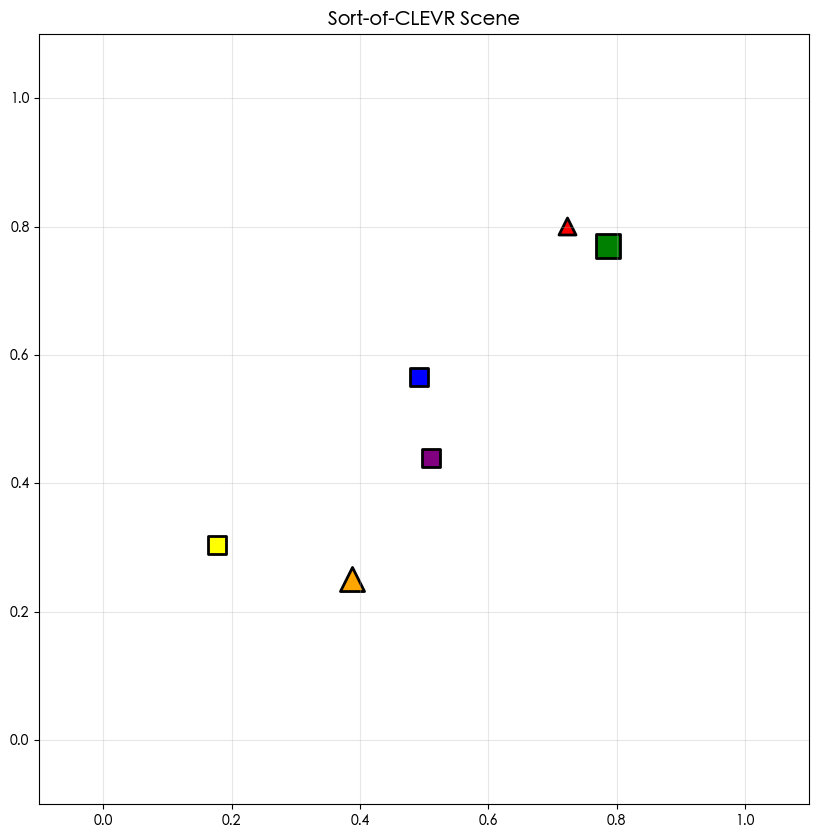

In [5]:
def visualize_scene(scene, dataset):
    """Visualize Sort-of-CLEVR scene"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Color mapping
    color_map = {
        'red': 'red',
        'blue': 'blue',
        'green': 'green',
        'orange': 'orange',
        'yellow': 'yellow',
        'purple': 'purple'
    }
    
    for obj in scene:
        x, y = obj['x'], obj['y']
        color = color_map[dataset.colors[obj['color']]]
        shape = dataset.shapes[obj['shape']]
        size = 300 if obj['size'] == 1 else 150
        
        if shape == 'circle':
            ax.scatter([x], [y], s=size, c=color, marker='o', edgecolors='black', linewidths=2)
        elif shape == 'square':
            ax.scatter([x], [y], s=size, c=color, marker='s', edgecolors='black', linewidths=2)
        else:  # triangle
            ax.scatter([x], [y], s=size, c=color, marker='^', edgecolors='black', linewidths=2)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title('Sort-of-CLEVR Scene', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.show()

visualize_scene(scene, dataset)

## 对象表示编码器

In [6]:
def encode_object(obj, dataset):
    """
    Encode object as vector:
    [x, y, color_one_hot, shape_one_hot, size_one_hot]
    """
    # Position
    pos = np.array([obj['x'], obj['y']])
    
    # One-hot encodings
    color_oh = np.zeros(len(dataset.colors))
    color_oh[obj['color']] = 1
    
    shape_oh = np.zeros(len(dataset.shapes))
    shape_oh[obj['shape']] = 1
    
    size_oh = np.zeros(len(dataset.sizes))
    size_oh[obj['size']] = 1
    
    # Concatenate
    encoding = np.concatenate([pos, color_oh, shape_oh, size_oh])
    return encoding

def encode_question(question_text, ref_color, dataset):
    """
    Encode question as vector (simplified)
    In practice: use LSTM or embeddings
    """
    # One-hot for reference color
    color_oh = np.zeros(len(dataset.colors))
    if ref_color is not None:
        color_oh[ref_color] = 1
    
    # Question type (simplified: 1 for relational, 0 for non-relational)
    is_relational = 1.0 if 'closest' in question_text else 0.0
    
    return np.concatenate([color_oh, [is_relational]])

# Test encoding
obj_encoding = encode_object(scene[0], dataset)
print(f"Object encoding shape: {obj_encoding.shape}")
print(f"Object encoding: {obj_encoding}")

q_encoding = encode_question("Shape of object closest to red?", 0, dataset)
print(f"\nQuestion encoding shape: {q_encoding.shape}")

Object encoding shape: (13,)
Object encoding: [0.51143641 0.44014845 0.         0.         0.         0.
 0.         1.         0.         1.         0.         1.
 0.        ]

Question encoding shape: (7,)


## 完整流程：场景 → 对象 → RN → 答案

In [7]:
# Create relation network with correct dimensions
object_dim = 2 + len(dataset.colors) + len(dataset.shapes) + len(dataset.sizes)
query_dim = len(dataset.colors) + 1

rn_visual = RelationNetwork(
    object_dim=object_dim,
    query_dim=query_dim,
    g_hidden_dims=[64, 64, 32],
    f_hidden_dims=[64, 32],
    output_dim=len(dataset.shapes)  # Predict shape
)

# Encode scene
encoded_objects = [encode_object(obj, dataset) for obj in scene]

# Generate question
question, answer, qtype = dataset.generate_question(scene, 'relational')

# Extract reference color from question (simplified)
ref_color = None
for i, color in enumerate(dataset.colors):
    if color in question.lower():
        ref_color = i
        break

encoded_question = encode_question(question, ref_color, dataset)

# Run relation network
prediction = rn_visual.forward(encoded_objects, encoded_question)
predicted_shape = np.argmax(prediction)

print(f"Question: {question}")
print(f"True answer: {dataset.shapes[answer]}")
print(f"Predicted answer: {dataset.shapes[predicted_shape]}")
print(f"\n(Model is untrained, so random prediction)")

Question: Shape of object closest to red?
True answer: square
Predicted answer: circle

(Model is untrained, so random prediction)


## 可视化对象之间的关系

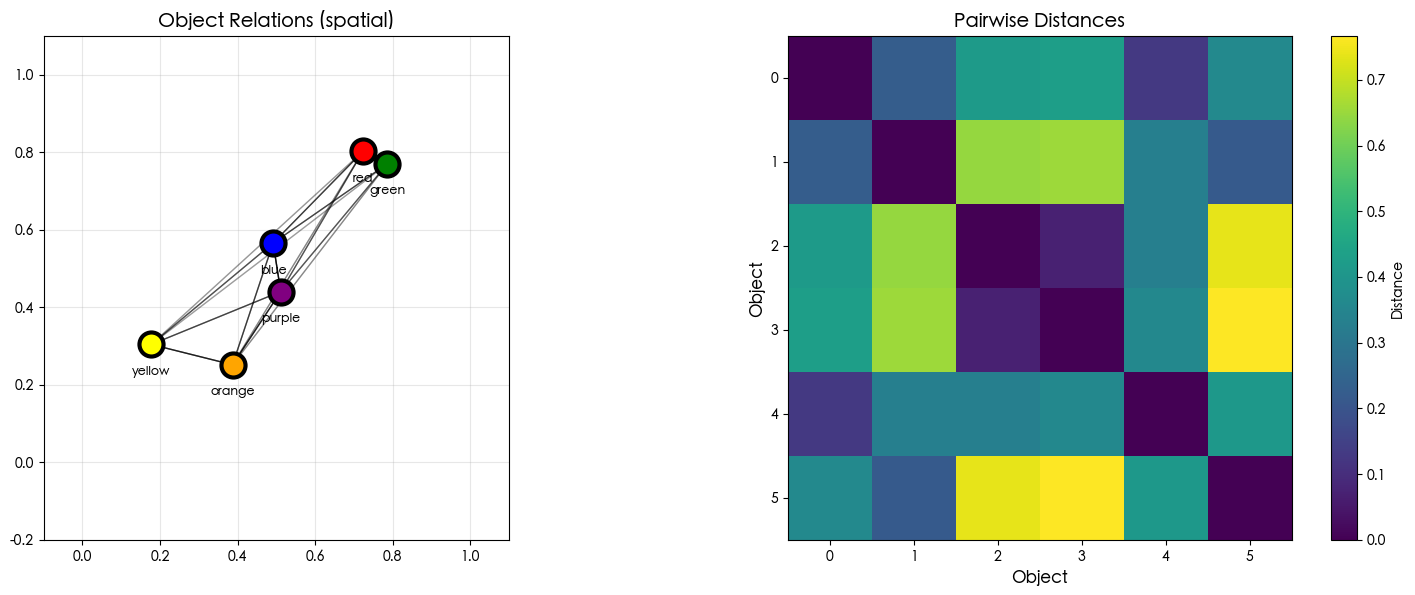


Relation Network considers ALL 30 pairs!


In [8]:
# Compute pairwise distances (example of relations)
n_objects = len(scene)
distance_matrix = np.zeros((n_objects, n_objects))

for i in range(n_objects):
    for j in range(n_objects):
        dist = np.sqrt((scene[i]['x'] - scene[j]['x'])**2 + 
                      (scene[i]['y'] - scene[j]['y'])**2)
        distance_matrix[i, j] = dist

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scene with connections
color_map = {'red': 'red', 'blue': 'blue', 'green': 'green', 
            'orange': 'orange', 'yellow': 'yellow', 'purple': 'purple'}

for i, obj_i in enumerate(scene):
    for j, obj_j in enumerate(scene):
        if i != j:
            # Draw connection (thicker = closer)
            dist = distance_matrix[i, j]
            alpha = np.exp(-dist * 2)  # Closer objects = higher alpha
            ax1.plot([obj_i['x'], obj_j['x']], [obj_i['y'], obj_j['y']], 
                    'k-', alpha=alpha, linewidth=1)

for obj in scene:
    color = color_map[dataset.colors[obj['color']]]
    ax1.scatter([obj['x']], [obj['y']], s=300, c=color, 
               edgecolors='black', linewidths=3, zorder=5)
    ax1.text(obj['x'], obj['y']-0.08, dataset.colors[obj['color']], 
            ha='center', fontsize=9, fontweight='bold')

ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.2, 1.1)
ax1.set_aspect('equal')
ax1.set_title('Object Relations (spatial)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Distance matrix
im = ax2.imshow(distance_matrix, cmap='viridis')
ax2.set_xlabel('Object', fontsize=12)
ax2.set_ylabel('Object', fontsize=12)
ax2.set_title('Pairwise Distances', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax2, label='Distance')

plt.tight_layout()
plt.show()

print(f"\nRelation Network considers ALL {n_objects * (n_objects - 1)} pairs!")

## 排列不变性测试

In [9]:
# Test that RN is invariant to object order
test_objects = [np.random.randn(object_dim) for _ in range(4)]
test_query = np.random.randn(query_dim)

# Original order
output1 = rn_visual.forward(test_objects, test_query)

# Shuffled order
shuffled_objects = test_objects.copy()
np.random.shuffle(shuffled_objects)
output2 = rn_visual.forward(shuffled_objects, test_query)

# Check if outputs are the same
diff = np.linalg.norm(output1 - output2)

print("Permutation Invariance Test:")
print(f"Original output: {output1[:4]}...")
print(f"Shuffled output: {output2[:4]}...")
print(f"Difference: {diff:.10f}")
print(f"\n{'✓ PASSED' if diff < 1e-10 else '✗ FAILED'}: RN is permutation invariant!")

Permutation Invariance Test:
Original output: [-3.09552689e-08 -3.46523907e-07  1.97613770e-07]...
Shuffled output: [-3.09552689e-08 -3.46523907e-07  1.97613770e-07]...
Difference: 0.0000000000

✓ PASSED: RN is permutation invariant!


## 与基线对比（无关系推理）

In [10]:
class BaselineNetwork:
    """
    Baseline: just concatenate all objects + query, no explicit relations
    """
    def __init__(self, object_dim, query_dim, max_objects, output_dim):
        # Concatenate all objects + query
        input_dim = object_dim * max_objects + query_dim
        self.mlp = MLP(input_dim, [128, 64], output_dim)
        self.max_objects = max_objects
        self.object_dim = object_dim
    
    def forward(self, objects, query):
        # Pad or truncate to max_objects
        padded = []
        for i in range(self.max_objects):
            if i < len(objects):
                padded.append(objects[i])
            else:
                padded.append(np.zeros(self.object_dim))
        
        # Concatenate everything
        concat = np.concatenate(padded + [query])
        return self.mlp.forward(concat)

# Create baseline
baseline = BaselineNetwork(object_dim, query_dim, max_objects=10, output_dim=len(dataset.shapes))

# Test
baseline_output = baseline.forward(encoded_objects, encoded_question)

print("Baseline Network (no explicit relations):")
print(f"Output: {baseline_output}")
print(f"\nBaseline doesn't explicitly reason about pairs!")

Baseline Network (no explicit relations):
Output: [ 1.89677096e-04  4.62062828e-05 -4.22531018e-04]

Baseline doesn't explicitly reason about pairs!


## 关键要点

### 关系网络 (RN) 公式：

$$
\text{RN}(O) = f_\phi \left( \sum_{i,j} g_\theta(o_i, o_j, q) \right)
$$

其中：
- $O = \{o_1, o_2, ..., o_n\}$：对象集合
- $g_\theta$：关系函数 (MLP) - 推理成对
- $f_\phi$：聚合函数 (MLP) - 组合关系
- $q$：查询/上下文

### 关键属性：

1. **显式成对关系**： 
   - 考虑所有 $n^2$ 对（或 $\binom{n}{2}$ 唯一对）
   - 每对由 $g_\theta$ 独立处理

2. **排列不变**：
   - 求和聚合 → 顺序不重要
   - $\text{RN}(\{o_1, o_2\}) = \text{RN}(\{o_2, o_1\})$

3. **组合性**：
   - 可插入任何架构
   - 来自 CNN、LSTM 等的对象

### 架构细节：

**用于视觉 QA**：
```
图像 → CNN → 特征图 → 对象（空间位置）
问题 → LSTM → 查询嵌入
对象 + 查询 → RN → 答案
```

**用于文本**：
```
句子 → LSTM → 词嵌入 → 对象
查询 → 嵌入
对象 + 查询 → RN → 答案
```

### 计算复杂度：

- **对数**：$O(n^2)$，其中 $n$ = 对象数量
- **$g_θ$ 评估**：$n^2$ 次前向传递
- 如果排除自对可以是 $i \neq j$ → $n(n-1)$ 对

### 结果：

**Sort-of-CLEVR**：
- 关系问题：96% (RN) vs 63% (CNN 基线)
- 非关系：98% (RN) vs 98% (CNN)

**CLEVR**（完整数据集）：
- 95.5% 准确率（超人性能！）
- 之前最佳：68.5%

**bAbI**：
- 20 个任务中 18 个使用单一模型
- 在关系推理任务上表现强劲

### 为什么有效：

1. **归纳偏差**：显式地对关系建模
2. **数据效率**：结构化计算 → 需要更少数据
3. **可解释性**：可以可视化 $g_\theta$ 输出
4. **泛化**：学习关系模式

### 与其他方法的对比：

| 方法 | 成对关系 | 排列不变 | 复杂度 |
|----------|-------------------|--------------|------------|
| CNN | 隐式 | ✗ | $O(n)$ |
| RNN/LSTM | 顺序 | ✗ | $O(n)$ |
| Attention | 加权成对 | ✓ | $O(n^2)$ |
| **RN** | **显式** | **✓** | **$O(n^2)$** |
| Graph NN | 显式（边） | ✓ | $O(|E|)$ |

### 扩展：

- **自注意力**：关系推理的特殊情况
- **Transformers**：注意力 = 关系推理！
- **图神经网络**：RN 在图结构上
- **关系 LSTM**：RN + 循环

### 局限性：

- $O(n^2)$ 复杂度（对大 $n$ 来说很昂贵）
- 求和聚合可能丢失信息
- 需要对象提取（对图像来说非平凡）

### 应用：

- 视觉 QA
- 物理预测
- 多智能体系统
- 图推理
- 关系数据库
- 任何有结构化对象的任务！